In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
import re

import matplotlib
import matplotlib.cm as mplcm
import matplotlib.colors as colors

In [95]:
import warnings
warnings.filterwarnings('ignore')

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2020.11-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
denmark_reinfections = pd.read_csv("/project/biocomplexity/biosurveillance/gisaid/gisaid_hcov-19_2022_03_10_04.Denmark.reinf.tsv", parse_dates=["Collection date"], sep = "\t").rename(columns={"Collection date":"date"}).dropna(subset=["Lineage"])
denmark_reinfections["num_infections"] = denmark_reinfections["Additional host information"].apply(lambda row: int(row.split(",")[0].split("n_infections=")[-1])) #.date = pd.to_datetime(denmark_reinfections.date)
denmark_reinfections.Lineage = denmark_reinfections.Lineage.apply(lambda row: apply_rules(row, combined_rules))

In [84]:
reinfection_firsts = denmark_reinfections[denmark_reinfections.Lineage.isin(combined_names)].groupby("Lineage").date.min()
reinfection_firsts = reinfection_firsts.to_dict()

In [23]:
all_metadata = pd.read_csv("/project/biocomplexity/biosurveillance/gisaid/metadata_2022-03-07_22-35.tsv.gz", sep = "\t", compression="gzip")

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2020.11-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [39]:
def apply_rules(name, rules):
    for orig, replacement in rules.items():
        name = re.sub(orig, replacement, name)
        
    return name

"""Combined Lineages Params"""
combined_rules = {"AY.*":"B.1.617", "B.1.617.*":"B.1.617", "42[79]":"42X", "\.[12]$":"", "BA.*":"B.1.1.529", "P":"P.1"}
combined_names = ['B.1.1.529', 'B.1.1.7', 'B.1.617', "B.1.351", 'B.1.621', 'P.1']
reinfection_colors = dict(zip(combined_names + ["other"], list('bgrcmyk')))
reinfection_colors

{'B.1.1.529': 'b',
 'B.1.1.7': 'g',
 'B.1.617': 'r',
 'B.1.351': 'c',
 'B.1.621': 'm',
 'P.1': 'y',
 'other': 'k'}

In [91]:
def get_prevalence_UT95(prevalence, variant = "B.1.1.529", genomic_budget=16, day_start=None):

    prevalence = prevalence[[variant]]
    complement = (1 - prevalence) ** genomic_budget
    prevalence["cum_prob"] = 1 - complement.cumprod()
    detection_date = prevalence[prevalence.cum_prob >= 0.95].index.min()
    
    return detection_date

In [88]:
all_denmark = all_metadata[all_metadata.country == "Denmark"] #.groupby([""])
all_denmark.data = pd.to_datetime(all_denmark.date)
all_denmark_prevalence = all_denmark.value_counts(["date", "pango_lineage"]).reset_index().pivot(index="date", columns = "pango_lineage", values=0).fillna(0)
all_denmark_prevalence.columns = [apply_rules(c, combined_rules) for c in all_denmark_prevalence.columns]
all_denmark_prevalence["other"] = all_denmark_prevalence[[c for c in all_denmark_prevalence.columns if c not in combined_names]].sum(axis=1)
all_denmark_prevalence = all_denmark_prevalence[combined_names + ["other"]]
all_denmark_prevalence = all_denmark_prevalence.groupby(all_denmark_prevalence.columns, axis=1).sum()
all_denmark_prevalence = (all_denmark_prevalence.T / all_denmark_prevalence.sum(axis=1)).T.rolling(7).mean()
all_denmark_prevalence.index = pd.to_datetime(all_denmark_prevalence.index)


<ipython-input-88-dbf2627a705d>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  all_denmark.data = pd.to_datetime(all_denmark.date)


In [96]:
ut95_date = dict()
for var in all_denmark_prevalence:
    ut95_date[var] = get_prevalence_UT95(all_denmark_prevalence, var)

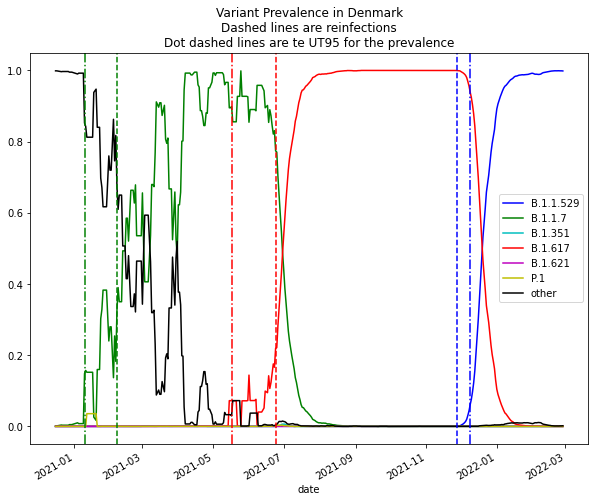

In [99]:
fig, ax = plt.subplots(figsize=(10,8))
all_denmark_prevalence.loc["2020-12-15":].plot(ax=ax, color=[reinfection_colors[c] for c in all_denmark_prevalence.columns])
for var, date in reinfection_firsts.items():
    ax.axvline(pd.to_datetime(date), color = reinfection_colors[var], linestyle = "--")
    ax.axvline(pd.to_datetime(ut95_date[var]), color = reinfection_colors[var], linestyle = "-.")
    
ax.set_title("Variant Prevalence in Denmark\nDashed lines are reinfections\nDot dashed lines are te UT95 for the prevalence")
plt.savefig("denmark_variant_prevalence_and_reinfections.png", facecolor="white", dpi=100)

In [2]:
def get_state_variants(state, data_orig, rolling=False, normalize=True):
    
    data = data_orig.copy().loc[state]
    samples = data.sum(axis=1)
        
    if rolling:
        data = data.rolling(7).mean()
    else:  
        data = data.apply(lambda col: savgol_filter(col, 31, 1), axis=0)
        
    data = data.where(data > 0, other=0)
    data.other = data.other.replace(0, 0.001)
    if normalize:
        data = data.divide(data.sum(axis=1), axis=0)
    data["samples"] = samples
    data["days"] = data.index
    data.days = (data.days - data.index.min()).dt.days
    
    if state in ["US", "USA"]:
        data = data[data.samples > 200]
    
    return data

In [3]:
def apply_rules(name, rules):
    for orig, replacement in rules.items():
        name = re.sub(orig, replacement, name)
        
    return name

def aggregate_with_rules(rules, names, orig_data):
    data = orig_data.copy()
    data.columns = [apply_rules(c, rules) for c in data.columns]
    data = data.groupby(data.columns, axis=1).sum()
    data["other"] = data[[c for c in data.columns if c not in names or c == "other"]].sum(axis=1)
    data = data.drop(columns = [c for c in data.columns if c not in names and c != "other"])
    names_in_col = [c for c in names if c in data.columns]
    names_not_found = [c for c in names if c not in data.columns]
    if names_not_found:
        print(f"Did not find variants {','.join(names_not_found)} in the base data")
    data = data[names_in_col + ["other"]]
    
    data.index = pd.to_datetime(data.index)
    
    return data

def get_color_map(name, number):
    cm = plt.get_cmap(name)
    cNorm  = colors.Normalize(vmin=0, vmax=number)
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
    tab_variant_colors = [scalarMap.to_rgba(i) for i in range(number)]
    return tab_variant_colors

In [4]:
def plot_state_variants(ax, data_orig, rolling=False, normalize=True, stackplot=True, start_at="2021-01-01", variant_names = None):
    
    if variant_names is not None:
        variant_names = list(variant_names)
        data = data[variant_names]
        
    else:
        data = data_orig.copy()
        variant_names = data.columns

#     data = get_state_variants(state, data, rolling=rolling, normalize=normalize)
    data = data.loc[start_at:]
#     data = data.drop(columns=["samples", "days"])
        
    if stackplot:
        ax.set_prop_cycle(color=get_color_map("tab20", data.shape[1]))
        ax.stackplot(data.index, data.T, labels=data.columns)
    else:
        ax.set_prop_cycle(color=get_color_map("tab20", data.shape[1]))
        data.plot(ax=ax, linewidth=4)
    
    ax.legend(loc="upper left")   
    
    ax.set_ylim(0,1.05)
    ax.set_xlim(data.index.min(), data.index.max())


In [5]:
base_data = "/project/biocomplexity/biosurveillance/gisaid/"
reinfections = pd.read_csv(base_data + "metadata_2022-02-22_19-16.Bangledash.reinfection2.tsv", sep="\t")

In [6]:
reinfections.data = pd.to_datetime(reinfections.date)
reinfections = reinfections[["date", "pango_lineage"]]
reinfections.pango_lineage.unique()

<ipython-input-6-2f6212325a6b>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  reinfections.data = pd.to_datetime(reinfections.date)


array(['B.1.1.25', 'B.1', 'B.1.36.16', 'B.1.351.3', 'B.1.1.7', 'AY.122',
       'AY.39', 'AY.54', 'B.1.617.2'], dtype=object)

In [7]:
rolling = True

all_variants = pd.read_csv(base_data + "metadata_2022-02-22_19-16.Bangledash.tsv", sep="\t")
all_variants = all_variants.value_counts(subset=["date", "pango_lineage"]).reset_index().pivot(index="date", columns = "pango_lineage", values=0).fillna(0)
all_variants = all_variants.rename(columns = {"None":"other"})

if rolling:
    all_variants = all_variants.rolling(7).mean()
else:  
    all_variants = all_variants.apply(lambda col: savgol_filter(col, 31, 1), axis=0)
    
all_variants = all_variants.divide(all_variants.sum(axis=1), axis=0)

In [8]:
"""Combined Lineages Params"""
combined_rules = {"AY.*":"B.1.617", "B.1.351*":"B.1.351", "42[79]":"42X", "\.[12]$":"", "BA.*":"B.1.1.529", "P":"P.1"}
combined_names = ['B.1.1.529', 'B.1.1.7', 'B.1.617', "B.1.351", 'B.1.621', 'P.1', ]

reinfection_colors = dict(zip(combined_names + ["other"], list('bgrcmyk')))

combined_variants = aggregate_with_rules(combined_rules, combined_names, all_variants)
# combined_variants.index

Did not find variants B.1.621,P.1 in the base data


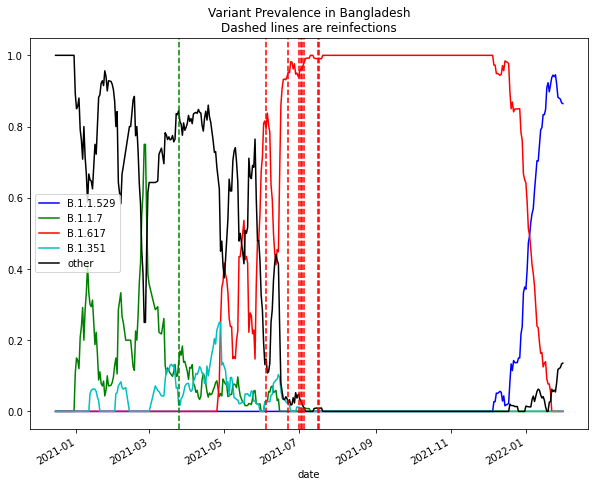

In [9]:
fig, ax = plt.subplots(figsize=(10,8))

combined_variants.loc["2020-12-15":].plot(ax=ax, color=[reinfection_colors[c] for c in combined_variants.columns])

for ix, row in reinfections.iterrows():
#     print(row)
    ruled_name = apply_rules(row.pango_lineage, combined_rules)
    if ruled_name in combined_names:
        ax.axvline(row.date, linestyle= "--", color=reinfection_colors[ruled_name])
        
ax.set_title("Variant Prevalence in Bangladesh\nDashed lines are reinfections")
plt.savefig("bangladesh_revised.png", facecolor="white", dpi=100)

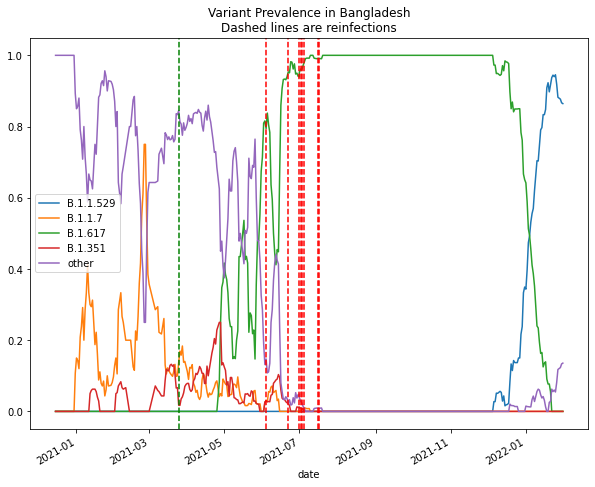

In [92]:
fig, ax = plt.subplots(figsize=(10,8))

combined_variants.loc["2020-12-15":].plot(ax=ax)

for ix, row in reinfections.iterrows():
#     print(row)
    ruled_name = apply_rules(row.pango_lineage, combined_rules)
    if ruled_name in combined_names:
        ax.axvline(row.date, linestyle= "--", color=reinfection_colors[ruled_name])
        
ax.set_title("Variant Prevalence in Bangladesh\nDashed lines are reinfections")
plt.savefig("bangladesh_variant_prevalence_and_reinfection.png", dpi=100, facecolor="white", bbox_inches="tight")

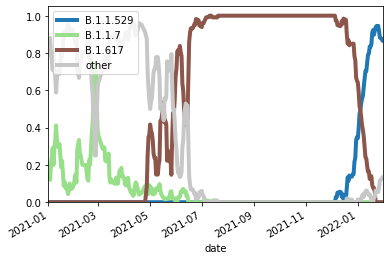

In [64]:
fig, ax = plt.subplots()

plot_state_variants(ax, combined_variants, stackplot=False)